<a href="https://colab.research.google.com/github/Deepikadandolu/Internship/blob/main/rp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1. install dependency
!pip install tensorflow scikit-learn matplotlib pandas numpy
!pip uninstall -y yafs
!pip install git+https://github.com/acsicuib/YAFS.git


  Cloning https://github.com/acsicuib/YAFS.git to /tmp/pip-req-build-jrp50e3t
  Running command git clone --filter=blob:none --quiet https://github.com/acsicuib/YAFS.git /tmp/pip-req-build-jrp50e3t
  Resolved https://github.com/acsicuib/YAFS.git to commit 7d58d0650c6e1fc15cc6b2c8eac58b51ab5c086f
  Preparing metadata (setup.py) ... done
  Created wheel for yafs: filename=yafs-0.3.0-py2.py3-none-any.whl size=32542 sha256=0f7cd434009219de25c31a680a54059c1e817908528ad3561d7944c47e130a96
  Stored in directory: /tmp/pip-ephem-wheel-cache-37fi9hg6/wheels/40/33/b1/fc25993dec43628d517d63d32511dc6eb9de5247b7cf23c98e
Successfully built yafs


In [ ]:
#conformation
import yafs
import pkgutil

print("YAFS version:", yafs.__version__)
print("Modules inside yafs:")
print([name for _,name,_ in pkgutil.iter_modules(yafs.__path__)])


YAFS version: 1.0
Modules inside yafs:
['action', 'application', 'core', 'distribution', 'metrics', 'path_routing', 'placement', 'population', 'selection', 'stats', 'topology']


In [ ]:
#2. imports and seed setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from yafs.core import Sim
from yafs.topology import Topology
from yafs.application import Application, Message
from yafs.population import Population
from yafs.placement import Placement
from yafs.path_routing import DeviceSpeedAwareRouting
from yafs.distribution import deterministic_distribution

# Seed
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [ ]:
import inspect
import yafs.path_routing

print(dir(yafs.path_routing))

['Counter', 'DeviceSpeedAwareRouting', 'Selection', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nx']


In [ ]:
#3. generating realistic workload data sheet
def generate_realistic_workload(num_samples=1000, seed=42):
    np.random.seed(seed)
    t = np.arange(num_samples)

    baseline = 10000 + 2000*np.sin(2*np.pi*t/24)
    bursts = np.zeros(num_samples)
    burst_times = np.random.choice(num_samples, int(num_samples*0.05), replace=False)
    bursts[burst_times] = np.random.uniform(20000, 50000, len(burst_times))
    noise = np.random.normal(0, 1500, num_samples)

    cpu_cycles = np.clip(baseline + bursts + noise, 500, None).astype(int)

    data = {
        "time": t,
        "cpu_cycles": cpu_cycles,
        "task_size": (cpu_cycles * 0.5).astype(int),
        "bandwidth": np.random.uniform(0.5, 10, num_samples),
        "delay": np.random.uniform(1, 30, num_samples),
        "processing_speed": np.random.uniform(2e5, 1e6, num_samples),
        "energy": np.random.uniform(0.1, 5, num_samples)
    }
    return pd.DataFrame(data)

df = generate_realistic_workload()
df.head()


,time,cpu_cycles,task_size,bandwidth,delay,processing_speed,energy
0,0,10764,5382,2.884183,16.042329,662245.640201,4.620758
1,1,12388,6194,8.580853,6.201576,892881.236302,3.834839
2,2,12448,6224,5.831616,29.149620,431551.617296,2.999413
3,3,11537,5768,5.472214,4.285802,574144.969988,1.040915
4,4,11000,5500,1.590304,12.704429,695511.975493,3.366760


In [ ]:
#4. normalize dataset
scaler = MinMaxScaler()
cols = ["cpu_cycles","task_size","bandwidth","delay","processing_speed","energy"]

df_scaled = df.copy()
df_scaled[cols] = scaler.fit_transform(df[cols])
df_scaled.head()


,time,cpu_cycles,task_size,bandwidth,delay,processing_speed,energy
0,0,0.122400,0.122402,0.251506,0.518616,0.579097,0.922725
1,1,0.150854,0.150857,0.852472,0.178907,0.868051,0.761230
2,2,0.151905,0.151908,0.562443,0.971087,0.290071,0.589562
3,3,0.135944,0.135929,0.524528,0.112774,0.468720,0.187118
4,4,0.126535,0.126537,0.115009,0.403390,0.620775,0.665046


In [ ]:
#5. prepare lstm seq
def create_sequences(series, window=10):
    X, y = [], []
    for i in range(len(series)-window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

window_size = 10
series = df_scaled['cpu_cycles'].values

X, y = create_sequences(series, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

X.shape, y.shape


((990, 10, 1), (990,))

In [ ]:
#6. build lstm model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

model = build_lstm((window_size, 1))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 - 6s - 253ms/step - loss: 0.0223 - val_loss: 0.0296
Epoch 2/50
25/25 - 0s - 17ms/step - loss: 0.0209 - val_loss: 0.0291
Epoch 3/50
25/25 - 1s - 27ms/step - loss: 0.0209 - val_loss: 0.0288
Epoch 4/50
25/25 - 0s - 17ms/step - loss: 0.0208 - val_loss: 0.0288
Epoch 5/50
25/25 - 0s - 16ms/step - loss: 0.0206 - val_loss: 0.0288
Epoch 6/50
25/25 - 1s - 25ms/step - loss: 0.0205 - val_loss: 0.0285
Epoch 7/50
25/25 - 1s - 28ms/step - loss: 0.0208 - val_loss: 0.0290
Epoch 8/50
25/25 - 2s - 67ms/step - loss: 0.0206 - val_loss: 0.0290
Epoch 9/50
25/25 - 1s - 43ms/step - loss: 0.0206 - val_loss: 0.0283
Epoch 10/50
25/25 - 1s - 37ms/step - loss: 0.0204 - val_loss: 0.0281
Epoch 11/50
25/25 - 1s - 33ms/step - loss: 0.0203 - val_loss: 0.0281
Epoch 12/50
25/25 - 1s - 48ms/step - loss: 0.0204 - val_loss: 0.0282
Epoch 13/50
25/25 - 1s - 58ms/step - loss: 0.0203 - val_loss: 0.0280
Epoch 14/50
25/25 - 1s - 53ms/step - loss: 0.0203 - val_loss: 0.0282
Epoch 15/50
25/25 - 1s - 39ms/step - loss:

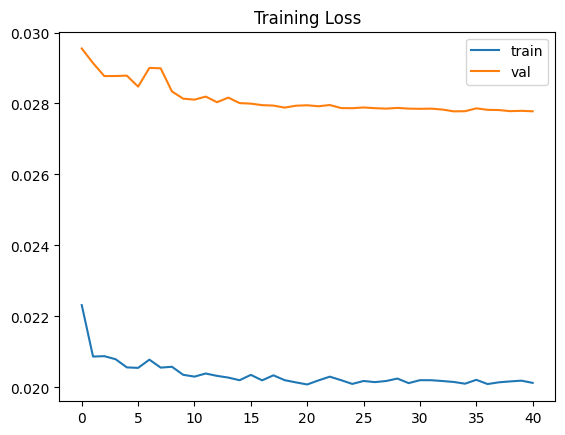

In [ ]:
#7. train lstm
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")
plt.legend(); plt.title("Training Loss");
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


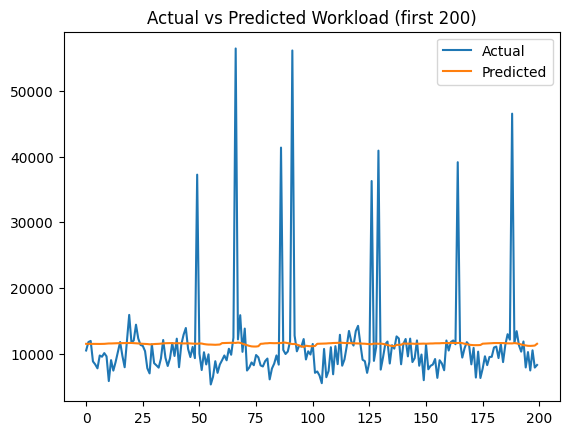

MSE: 70201061.31884974  MAE: 3691.763019637327


In [ ]:
#8. predict workload
pred_norm = model.predict(X).ravel()

def inverse_transform_cpu(vals):
    dummy = np.zeros((len(vals), len(cols)))
    dummy[:,0] = vals
    inv = scaler.inverse_transform(dummy)
    return inv[:,0]

predicted = inverse_transform_cpu(pred_norm)
actual = df['cpu_cycles'].values[window_size:]

plt.plot(actual[:200], label="Actual")
plt.plot(predicted[:200], label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Workload (first 200)")
plt.show()

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
print("MSE:", mse, " MAE:", mae)


In [ ]:
#9. prepare optimization input csa
L = len(predicted)

optimization_input = {
    "predicted_workload": predicted,
    "task_size": df['task_size'].values[window_size:window_size+L],
    "bandwidth": df['bandwidth'].values[window_size:window_size+L],
    "delay": df['delay'].values[window_size:window_size+L],
    "processing_speed": df['processing_speed'].values[window_size:window_size+L],
    "energy": df['energy'].values[window_size:window_size+L],
    "prop_delay": np.zeros(L),
    "num_tasks": L
}

L


990

In [ ]:
#10. csa funct
def quantize_o(o_cont):
    o_cont = np.clip(o_cont, -1, 1)
    return np.where(o_cont<=-0.5, -1,
           np.where(o_cont>=0.5, 1, 0)).astype(int)

def normalize_bandwidth(b, B_max):
    b = np.maximum(b, 0)
    s = b.sum()
    if s == 0: return np.ones_like(b)*(B_max/len(b))
    if s <= B_max: return b
    return b*(B_max/s)

def compute_cost_U(o, b, opt, p):
    tau = opt["task_size"]
    mu_ID = opt["processing_speed"]
    pID, pTX, pFS, pCD = p["p_ID"], p["p_tx"], p["p_FS"], p["p_CD"]
    muFS, muCD = p["mu_FS"], p["mu_CD"]
    L1, L2 = p["lambda1"], p["lambda2"]
    b = np.maximum(b, 1e-9)

    D_id = tau/mu_ID
    u_id = L1*D_id + L2*(D_id*pID)

    D_tx = tau/b
    D_fs = tau/muFS
    u_fs = L1*(D_tx+D_fs) + L2*(pTX*D_tx + pFS*D_fs)

    D_cd = tau/muCD
    u_cd = L1*(D_tx+D_cd) + L2*(pTX*D_tx+pCD*D_cd)

    return float(np.sum((1-o**2)*u_id + o*(o-1)/2*u_fs + o*(1+o)/2*u_cd))

def csa_optimize(opt, params, csa, seed=42):
    np.random.seed(seed)
    n = opt["num_tasks"]
    P = csa["pop_size"]; I = csa["max_iter"]; AP = csa["AP"]; FL = csa["FL"]; B_max=csa["B_max"]

    pop_o = np.random.uniform(-1,1,(P,n))
    pop_b = np.random.rand(P,n)
    for i in range(P): pop_b[i] = normalize_bandwidth(pop_b[i], B_max)

    mem_o = pop_o.copy()
    mem_b = pop_b.copy()
    mem_cost = np.array([compute_cost_U(quantize_o(mem_o[i]), mem_b[i], opt, params)
                         for i in range(P)])

    best_idx = np.argmin(mem_cost)
    best_o = quantize_o(mem_o[best_idx])
    best_b = mem_b[best_idx]
    best_cost = mem_cost[best_idx]
    hist=[best_cost]

    for _ in range(I):
        for i in range(P):
            j = np.random.randint(P)
            while j == i: j = np.random.randint(P)

            if np.random.rand()>AP:
                new_o = pop_o[i] + FL*np.random.rand(n)*(mem_o[j]-pop_o[i])
                new_b = pop_b[i] + FL*np.random.rand(n)*(mem_b[j]-pop_b[i])
            else:
                new_o = np.random.uniform(-1,1,n)
                new_b = np.random.rand(n)

            new_b = normalize_bandwidth(new_b, B_max)
            qo = quantize_o(new_o)
            cost = compute_cost_U(qo, new_b, opt, params)

            if cost < mem_cost[i]:
                mem_cost[i]=cost; mem_o[i]=new_o; mem_b[i]=new_b
                if cost < best_cost:
                    best_cost=cost; best_o=qo; best_b=new_b

            pop_o[i]=new_o; pop_b[i]=new_b

        hist.append(best_cost)

    return {"o": best_o, "b": best_b, "U": best_cost, "history":hist}


In [ ]:
#11. run csa optimization
params = {
    "p_ID":0.5, "p_tx":0.2, "p_FS":1.0, "p_CD":2.0,
    "mu_FS":1e6, "mu_CD":5e6,
    "lambda1":0.5, "lambda2":0.5
}

csa_params = {"pop_size":30, "max_iter":150, "AP":0.15, "FL":1.5, "B_max":50}

best = csa_optimize(optimization_input, params, csa_params)
best


{'o': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,
         1,  1, -1, -1,  1,  0,  0,  0,  0,  1,  1,  0, -1,  0,  0,  0,  0,
         0, -1, -1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, -1, -1, -1,
         0,  0,  0,  0,  1,  0, -1, -1, -1,  1,  0,  1, -1, -1,  0,  1,  0,
         0,  0,  0, -1,  0,  0,  0,  1, -1,  1,  0,  1, -1,  1, -1,  0, -1,
        -1, -1, -1,  1,  1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,
         0,  0, -1, -1,  0, -1,  0,  1,  0, -1,  0,  0, -1, -1, -1,  0,  0,
         0,  0, -1,  1,  0,  0,  0,  1,  0,  1,  1,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0,  0, -1,  0,  0,
         1,  0,  0,  0, -1, -1,  1,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,
         0,  0, -1, -1,  0,  0, -1,  1, -1,  0,  1,  1,  0,  0,  0,  0,  0,
         1,  0,  1,  0,  0,  1,  0,  1,  0,  0,  1, -1,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  1,  0,  1,  1, -1, -1,  1,  1,  1,  0,  1,  0,  0,
       

In [ ]:
#12. build yafs topology
subset = 30  # small demo
o_vec = best["o"][:subset]

topo = Topology()
entities=[]; links=[]

fog_nodes = [100,101,102]
cloud_id = 999

for i in range(subset):
    entities.append({"id":i,"type":"IOT"})
    links.append({"s":i,"d":fog_nodes[i%3],"BW":50,"LAT":5})

for f in fog_nodes:
    entities.append({"id":f,"type":"FOG"})
    links.append({"s":f,"d":cloud_id,"BW":200,"LAT":10})

entities.append({"id":cloud_id,"type":"CLOUD"})

topo.load({"entity":entities,"link":links})
print("Topology built.")


NameError: name 'best' is not defined

In [ ]:
#13. YAFS App + Placement Using CSA
app = Application("app")
app.set_modules([
    {"module_name":"sensor","module_type":Application.TYPE_SOURCE},
    {"module_name":"processor","module_type":Application.TYPE_MODULE},
    {"module_name":"sink","module_type":Application.TYPE_SINK}
])

m1 = Message("m1","sensor","processor",instructions=3000,bytes=100)
m2 = Message("m2","processor","sink",instructions=1000,bytes=50)
app.add_message(m1); app.add_message(m2)
app.add_source_messages("sensor", m1)
app.add_sink_messages("sink", m2)

placement = Placement("csaPlacement")

for i in range(subset):
    if o_vec[i] == 0:
        placement.map_module("processor", i)
    elif o_vec[i] == -1:
        placement.map_module("processor", fog_nodes[i%3])
    else:
        placement.map_module("processor", cloud_id)

placement.map_module("sink", cloud_id)


In [ ]:
#14. YAFS Population + Simulation
pop = Population("pop")
for i in range(subset):
    pop.set_src_node(i)
    pop.set_dst_module("sensor")
    pop.set_message(m1)
    pop.set_distribution(deterministic_distribution(10))

selector = Selectivity()
sim = Sim(topo, app, placement, pop, selector)

print("Running YAFS simulation...")
sim.run(stop_time=200)
print("Simulation complete.")


In [ ]:
#15. Final Results Table
result_df = pd.DataFrame({
    "Task": np.arange(subset),
    "Offloading_decision": o_vec[:subset],
    "Bandwidth_alloc": best["b"][:subset],
    "Predicted_workload": optimization_input["predicted_workload"][:subset]
})
result_df


In [ ]:
#16. Plot Offloading & Bandwidth
plt.figure(figsize=(12,3))
plt.bar(result_df["Task"], result_df["Bandwidth_alloc"])
plt.title("Bandwidth Allocation")
plt.show()

plt.figure(figsize=(12,3))
plt.bar(result_df["Task"], result_df["Offloading_decision"])
plt.title("Offloading Decision (-1=Fog,0=Local,1=Cloud)")
plt.show()
